### 📝 **Important Note Before Running This Notebook**

To ensure smooth execution of this notebook, please follow the setup instructions below **before running any cells**:

---

#### 📁 **Folder Structure**

Make sure the following folder structure exists **in the same directory as the notebook file** (`hotel_reviews_classification.ipynb`):

<pre>
hotel_review/
├── original_dataset/
├── processed_dataset/
├── rating_classification/
├── sentiment_analysis/
└── hotel_reviews_classification.ipynb
</pre>

---

#### 📥 **Download Required Files**

Download the original dataset files from the https://www.cs.cmu.edu/~jiweil/html/hotel-review.html and place them in the `original_dataset/` folder:

- `review.txt`
- `offering.txt`

> 📌 *Note* : This dataset consists of 878561 reviews (1.3GB) from 4333 hotels crawled from TripAdvisor. Pay attention that some of the reviews are written in French.

# Data Pre Processing

In [ ]:
from langdetect import detect
from tqdm import tqdm
import random

input_file = "original_dataset/review.txt"
output_file = "processed_dataset/reviews_english.txt"

non_french_reviews = []
french_samples = []

In [ ]:
from langdetect import detect
from tqdm import tqdm
import multiprocessing as mp

input_file = "original_dataset/review.txt"
output_file = "processed_dataset/reviews_english.txt"
num_samples = 3  # Number of French samples to show

with open(input_file, "r", encoding="utf-8") as f:
    lines = [line.strip() for line in f.readlines()]

def detect_lang(line):
    try:
        lang = detect(line)
    except:
        lang = "unknown"
    return (line, lang)

# multiprocessing for speed
with mp.Pool(mp.cpu_count()) as pool:
    results = list(tqdm(pool.imap(detect_lang, lines), total=len(lines), desc="Detecting languages"))

non_french_reviews = [line for line, lang in results if lang != "fr"]
french_samples = [line for line, lang in results if lang == "fr"][:num_samples]

# Save English reviews
with open(output_file, "w", encoding="utf-8") as f:
    for line in non_french_reviews:
        f.write(line + "\n")

# Show French examples
print("\n🧹 Removed the following French reviews:")
for i, sample in enumerate(french_samples, 1):
    print(f"\nFrench Sample {i}:\n{sample}")

print(f"\n✅ Cleaned reviews saved to: {output_file}")

In [ ]:
original_file = "original_dataset/review.txt"
cleaned_file = "processed_dataset/reviews_english.txt"

with open(original_file, "r", encoding="utf-8") as f:
    total_reviews = sum(1 for _ in f)

with open(cleaned_file, "r", encoding="utf-8") as f:
    english_reviews = sum(1 for _ in f)

french_removed = total_reviews - english_reviews

print(f"📄 Total reviews in original file      : {total_reviews}")
print(f"✅ English reviews after cleanup      : {english_reviews}")
print(f"🗑️  French reviews removed             : {french_removed}")

📄 Total reviews in original file      : 878561
✅ English reviews after cleanup      : 854341
🗑️  French reviews removed             : 24220


In [ ]:
import json
import pandas as pd
from pathlib import Path
from tqdm import tqdm

with open("offering.txt", "r", encoding="utf-8") as f:
    offerings = [json.loads(line) for line in tqdm(f, desc="Loading offerings")]

# Flatten offerings
flattened_offerings = []
for entry in offerings:
    flat = {
        "hotel_id": entry.get("id"),
        "name": entry.get("name"),
        "hotel_class": entry.get("hotel_class"),
        "region_id": entry.get("region_id"),
        "url": entry.get("url"),
        "phone": entry.get("phone"),
        "type": entry.get("type"),
        "address_region": entry.get("address", {}).get("region"),
        "address_street": entry.get("address", {}).get("street-address"),
        "address_postal_code": entry.get("address", {}).get("postal-code"),
        "address_locality": entry.get("address", {}).get("locality"),
    }
    flattened_offerings.append(flat)

df_offerings = pd.DataFrame(flattened_offerings)
df_offerings.to_csv("processed_dataset/offering.csv", index=False)
print("✅ Saved 'offering.csv' with shape:", df_offerings.shape)

with open("processed_dataset/reviews_english.txt", "r", encoding="utf-8") as f:
    reviews = [json.loads(line) for line in tqdm(f, desc="Loading reviews")]

# Flatten reviews
flattened_reviews = []
for entry in reviews:
    flat = {
        "review_id": entry.get("id"),
        "offering_id": entry.get("offering_id"),
        "title": entry.get("title"),
        "text": entry.get("text"),
        "num_helpful_votes": entry.get("num_helpful_votes"),
        "date": entry.get("date"),
        "date_stayed": entry.get("date_stayed"),
        "via_mobile": entry.get("via_mobile"),
    }

    # Flatten ratings
    ratings = entry.get("ratings", {})
    for k, v in ratings.items():
        flat[f"rating_{k}"] = v

    # Flatten author
    author = entry.get("author", {})
    flat.update({
        "author_username": author.get("username"),
        "author_location": author.get("location"),
        "author_id": author.get("id"),
        "author_num_reviews": author.get("num_reviews"),
        "author_num_cities": author.get("num_cities"),
        "author_num_helpful_votes": author.get("num_helpful_votes"),
        "author_num_type_reviews": author.get("num_type_reviews")
    })

    flattened_reviews.append(flat)

df_reviews = pd.DataFrame(flattened_reviews)
df_reviews.to_csv("processed_dataset/reviews_english.csv", index=False)
print("✅ Saved 'reviews_english.csv' with shape:", df_reviews.shape)

Loading offerings: 4333it [00:00, 451189.65it/s]


✅ Saved 'offering.csv' with shape: (4333, 11)


Loading reviews: 854341it [00:07, 107498.99it/s]


✅ Saved 'reviews_english.csv' with shape: (854341, 24)


In [ ]:
unique_values = df_offerings.nunique()
print("Number of unique values for each column in 'offering.csv':")
print(unique_values)

Number of unique values for each column in 'offering.csv':
hotel_id               4333
name                   4254
hotel_class               9
region_id                25
url                    4333
phone                     1
type                      1
address_region           17
address_street         4321
address_postal_code     909
address_locality         25
dtype: int64


In [ ]:
unique_values = df_reviews.nunique()
print("Number of unique values for each column in 'offering.csv':")
print(unique_values)

Number of unique values for each column in 'offering.csv':
review_id                                        854341
offering_id                                        3941
title                                            613126
text                                             853569
num_helpful_votes                                   100
date                                               3948
date_stayed                                         169
via_mobile                                            2
rating_service                                        5
rating_cleanliness                                    5
rating_overall                                        6
rating_value                                          5
rating_location                                       5
rating_sleep_quality                                  5
rating_rooms                                          5
author_username                                  527302
author_location                              

# Data Analysis

✅ Loaded offerings: (4333, 11)
✅ Loaded reviews: (854341, 24)
❗ Reviews with missing offering_id: 0
🏨 Number of unique hotels in offerings: 4333
📝 Total number of reviews: 854341
📊 Average number of reviews per hotel: 216.78

🏆 Top 10 Most Reviewed Hotels:
   hotel_id                                 name  review_count
0    214197          Hotel Pennsylvania New York          5091
1     93520                         Park Central          3646
2     93618             Waldorf Astoria New York          3441
3    122005                 The New Yorker Hotel          3341
4    223023                      Hudson New York          3214
5     93562                    Affinia Manhattan          3091
6     99766                  The Roosevelt Hotel          3017
7    611947                      Hilton New York          2942
8     93437            Edison Hotel Times Square          2816
9    249712  The Westin New York at Times Square          2798


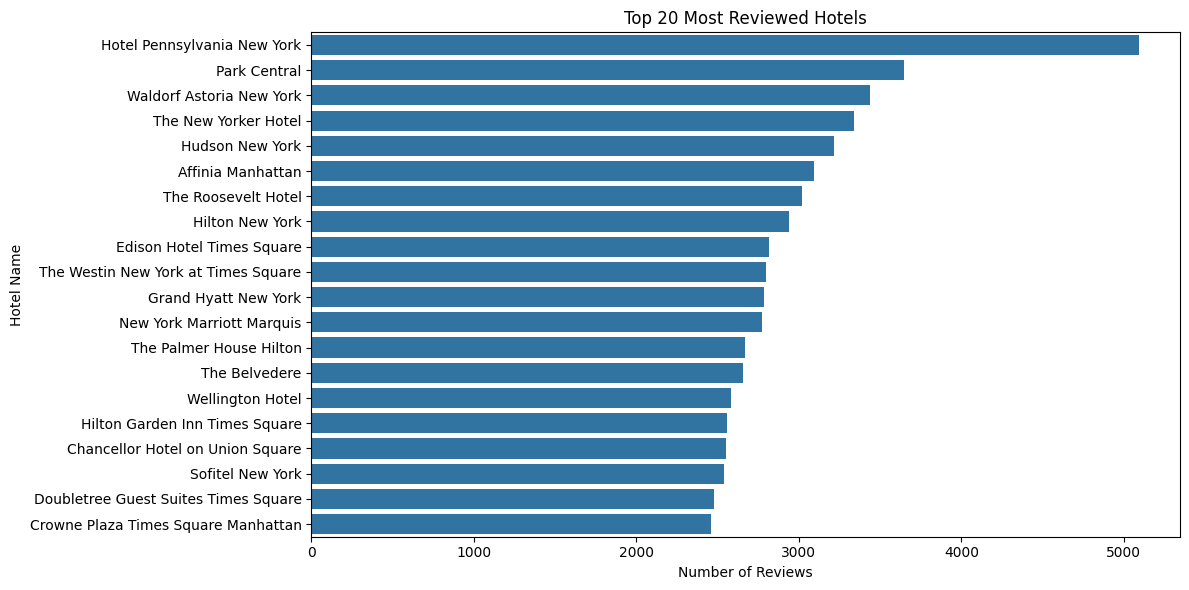

In [ ]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

df_hotels = pd.read_csv("processed_dataset/offering.csv")
df_reviews = pd.read_csv("processed_dataset/reviews_english.csv")

print("✅ Loaded offerings:", df_hotels.shape)
print("✅ Loaded reviews:", df_reviews.shape)

null_offering_ids = df_reviews['offering_id'].isnull().sum()
print(f"❗ Reviews with missing offering_id: {null_offering_ids}")

unique_hotels = df_hotels["hotel_id"].nunique()
print(f"🏨 Number of unique hotels in offerings: {unique_hotels}")

total_reviews = df_reviews.shape[0]
print(f"📝 Total number of reviews: {total_reviews}")

review_counts = df_reviews['offering_id'].value_counts().reset_index()
review_counts.columns = ['hotel_id', 'review_count']

merged = review_counts.merge(df_hotels, on="hotel_id", how="left")

avg_reviews_per_hotel = review_counts['review_count'].mean()
print(f"📊 Average number of reviews per hotel: {avg_reviews_per_hotel:.2f}")

# Top 10 most reviewed hotels
top10 = merged.head(10)
print("\n🏆 Top 10 Most Reviewed Hotels:")
print(top10[['hotel_id', 'name', 'review_count']])

# Save top 10 to CSV (optional)
top10.to_csv("top_10_most_reviewed_hotels.csv", index=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='review_count', y='name', data=merged.head(20))
plt.title("Top 20 Most Reviewed Hotels")
plt.xlabel("Number of Reviews")
plt.ylabel("Hotel Name")
plt.tight_layout()
plt.savefig("top_20_reviewed_hotels.png")
plt.show()


Unique values in the 'rating_overall' column:
[0.0, 1.0, 2.0, 3.0, 4.0, 5.0]


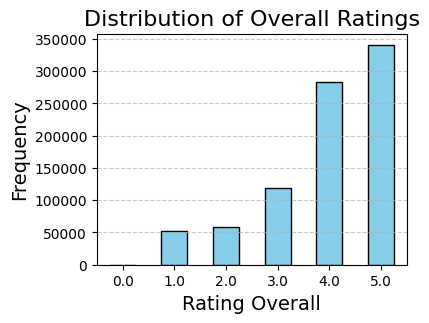

In [ ]:
import matplotlib.pyplot as plt

# Drop rows with missing values in 'rating_overall'
df_reviews['rating_overall'] = pd.to_numeric(df_reviews['rating_overall'], errors='coerce')
rating_counts = df_reviews['rating_overall'].value_counts().sort_index()
unique_values = df_reviews['rating_overall'].dropna().unique()
print("Unique values in the 'rating_overall' column:")
print(sorted(unique_values))

plt.figure(figsize=(4, 3))
rating_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Overall Ratings', fontsize=16)
plt.xlabel('Rating Overall', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Sentiment Analysis

In [ ]:
import pandas as pd

df = pd.read_csv("processed_dataset/reviews_english.csv")

# Add sentiment labels
def assign_sentiment(rating):
    if rating in [1, 2]:
        return 0  # Negative
    elif rating == 3:
        return 1  # Neutral
    elif rating in [4, 5]:
        return 2  # Positive
    else:
        return None

df["labels"] = df["rating_overall"].apply(assign_sentiment)

df = df.dropna(subset=["labels", "title", "text"])

df["text"] = df["title"].str.strip() + "\n" + df["text"].str.strip()

df_to_save = df[["text", "labels"]]
df_to_save["labels"] = df_to_save["labels"].astype(int)

print("\nSentiment label distribution (0 = Negative, 1 = Neutral, 2 = Positive):")
print(df_to_save["labels"].value_counts().sort_index())

df_to_save.to_csv("sentiment_analysis/sentiment_dataset.csv", index=False)
print("\n✅ Saved combined 'text' and 'labels' to 'sentiment_analysis/sentiment_dataset.csv'")

/tmp/ipykernel_3411194/718382501.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_save["labels"] = df_to_save["labels"].astype(int)



Sentiment label distribution (0 = Negative, 1 = Neutral, 2 = Positive):
labels
0    111628
1    118666
2    624033
Name: count, dtype: int64

✅ Saved combined 'text' and 'labels' to 'sentiment_analysis/sentiment_dataset.csv'


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("sentiment_analysis/sentiment_dataset.csv")

train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['labels'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['labels'], random_state=42)

train_df.to_csv("sentiment_analysis/sentiment_train.csv", index=False)
val_df.to_csv("sentiment_analysis/sentiment_val.csv", index=False)
test_df.to_csv("sentiment_analysis/sentiment_test.csv", index=False)

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")


Train size: 683461
Validation size: 85433
Test size: 85433


## DistilBERT

In [74]:
import psutil

# CPU info
num_cores = psutil.cpu_count(logical=True)
print(f"CPU Cores (Logical): {num_cores}")

# RAM info
ram_bytes = psutil.virtual_memory().total
ram_gb = ram_bytes / (1024 ** 3)
print(f"Total RAM: {ram_gb:.2f} GB")

CPU Cores (Logical): 32
Total RAM: 186.34 GB


### Parameters

In [75]:
import pandas as pd, numpy as np
import torch
from datasets import Dataset
from transformers import (DistilBertTokenizerFast, DistilBertForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding, TrainerCallback)

# Ensure GPU is used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Configurable hyperparameters
EPOCHS = 5
LEARNING_RATE = 1e-5  
WEIGHT_DECAY = 0.01
TRAIN_BATCH_SIZE = 128
EVAL_BATCH_SIZE = 128

CHECKPOINT = "distilbert-base-uncased"
OUTPUT_DIR = "sentiment_analysis/distilbert"

Using device: cuda


### Tokenization and Pre-Processing

In [ ]:
train_df = pd.read_csv("sentiment_analysis/sentiment_train.csv")
val_df = pd.read_csv("sentiment_analysis/sentiment_val.csv")
test_df = pd.read_csv("sentiment_analysis/sentiment_test.csv")

# convert sentiment labels from float to int
train_df["labels"] = train_df["labels"].astype(int)
val_df["labels"] = val_df["labels"].astype(int)
test_df["labels"] = test_df["labels"].astype(int)

# Convert to Hugging Face Datasets
train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)
test_ds = Dataset.from_pandas(test_df)

In [77]:
print(test_ds)
train_ds[0]

Dataset({
    features: ['text', 'labels'],
    num_rows: 85433
})


{'text': "“One of the best hotels I've stayed at”\nThree friends and I stayed at the Fairfield Inn & Suites Baltimore Downtown/Inner Harbor for one night. From the moment we arrived, until we left the next morning, the staff was incredibly friendly and helpful. Our room was clean and spacious, the bathroom was clean as well, and the beds were comfortable (though we didn't spend too much time in the room, as we came to Baltimore for a concert at the Ram's Head Live!, which was within walking distance to the hotel). They offer Valet Parking for $30 a night, which we decided to utilize because to park elsewhere was $18 a night, so for just $12 more, Valet was a better option because it was so much easier. We didn't make it to the continental breakfast, but upon checking out, we asked the valet where a good place to park was while we visited the National Aquarium (a brief walk from the hotel). He let us leave our vehicle at the hotel while we got lunch and went to the Aquarium, and provide

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained(CHECKPOINT)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

print("Tokenizing datasets...")

train_ds = train_ds.map(tokenize, batched=True, batch_size=4096, num_proc=30)
val_ds = val_ds.map(tokenize, batched=True, batch_size=4096, num_proc=30)
test_ds = test_ds.map(tokenize, batched=True, batch_size=4096, num_proc=30)

Tokenizing datasets...


Map (num_proc=30): 100%|██████████| 85433/85433 [00:10<00:00, 8486.74 examples/s] 


In [ ]:
train_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

train_ds[0]

{'labels': tensor(2),
 'input_ids': tensor([  101,  1523,  2028,  1997,  1996,  2190,  9275,  1045,  1005,  2310,
          4370,  2012,  1524,  2093,  2814,  1998,  1045,  4370,  2012,  1996,
         18986,  7601,  1004, 19796,  6222,  5116,  1013,  5110,  6496,  2005,
          2028,  2305,  1012,  2013,  1996,  2617,  2057,  3369,  1010,  2127,
          2057,  2187,  1996,  2279,  2851,  1010,  1996,  3095,  2001, 11757,
          5379,  1998, 14044,  1012,  2256,  2282,  2001,  4550,  1998, 22445,
          1010,  1996,  5723,  2001,  4550,  2004,  2092,  1010,  1998,  1996,
          9705,  2020,  6625,  1006,  2295,  2057,  2134,  1005,  1056,  5247,
          2205,  2172,  2051,  1999,  1996,  2282,  1010,  2004,  2057,  2234,
          2000,  6222,  2005,  1037,  4164,  2012,  1996,  8223,  1005,  1055,
          2132,  2444,   999,  1010,  2029,  2001,  2306,  3788,  3292,  2000,
          1996,  3309,  1007,  1012,  2027,  3749, 27238,  5581,  2005,  1002,
          2382,  

### Computing and Printing Metrices

In [80]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tabulate import tabulate

def print_metrics(results):
    label_names = ["Negative", "Neutral", "Positive"]

    print("\n\033[1m📊 Model Evaluation Metrics:\033[0m")
    general_metrics = [
        ["Accuracy", f"{results['accuracy']:.4f}"],
        ["Macro Precision", f"{results['macro_precision']:.4f}"],
        ["Macro Recall", f"{results['macro_recall']:.4f}"],
        ["Macro F1", f"{results['macro_f1']:.4f}"],
        ["Weighted Precision", f"{results['weighted_precision']:.4f}"],
        ["Weighted Recall", f"{results['weighted_recall']:.4f}"],
        ["Weighted F1", f"{results['weighted_f1']:.4f}"]
    ]
    print(tabulate(general_metrics, headers=["Metric", "Value"], tablefmt="fancy_grid"))

    print("\n\033[1m📊 Per-Class Metrics:\033[0m")
    class_metrics = {
        "Sentiment": label_names,
        "F1-Score": [f"{results[f'{l.lower()}_f1']:.4f}" for l in label_names],
        "Precision": [f"{results[f'{l.lower()}_precision']:.4f}" for l in label_names],
        "Recall": [f"{results[f'{l.lower()}_recall']:.4f}" for l in label_names]
    }
    print(tabulate(class_metrics, headers="keys", tablefmt="fancy_grid"))

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)

    # Macro and weighted
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro')
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(labels, preds, average='weighted')

    # Per-class
    precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(labels, preds, average=None)
    label_names = ["Negative", "Neutral", "Positive"]

    results = {
        "accuracy": accuracy_score(labels, preds),
        "macro_precision": precision_macro,
        "macro_recall": recall_macro,
        "macro_f1": f1_macro,
        "weighted_precision": precision_weighted,
        "weighted_recall": recall_weighted,
        "weighted_f1": f1_weighted
    }

    for i, label in enumerate(label_names):
        results[f"{label.lower()}_f1"] = f1_per_class[i]
        results[f"{label.lower()}_precision"] = precision_per_class[i]
        results[f"{label.lower()}_recall"] = recall_per_class[i]

    return results


from torch.utils.data import DataLoader
import torch

class VerboseCallback(TrainerCallback):
    def on_epoch_begin(self, args, state, control, **kwargs):
        print(f"\n🔁 Epoch {int(state.epoch) + 1} started...")

    def on_evaluate(self, args, state, control, **kwargs):
        print(f"\n📊 Evaluation after epoch {int(state.epoch)}:")

        # Re-run evaluation manually
        val_dataloader = DataLoader(val_ds, batch_size=EVAL_BATCH_SIZE)
        model.eval()

        all_logits = []
        all_labels = []

        with torch.no_grad():
            for batch in val_dataloader:
                inputs = {
                    "input_ids": batch["input_ids"].to(model.device),
                    "attention_mask": batch["attention_mask"].to(model.device)
                }
                labels = batch["labels"].to(model.device)
                outputs = model(**inputs)
                all_logits.append(outputs.logits.cpu())
                all_labels.append(labels.cpu())

        # Stack everything and compute metrics
        logits = torch.cat(all_logits).numpy()
        labels = torch.cat(all_labels).numpy()

        results = compute_metrics((logits, labels))
        print_metrics(results)

    def on_train_end(self, args, state, control, **kwargs):
        print("\n🏁 Training complete!")

### Model and Trainer Setup

In [ ]:
from math import ceil
model = DistilBertForSequenceClassification.from_pretrained(CHECKPOINT, num_labels=3).to(device)

args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    load_best_model_at_end=True,
    do_eval=True,
    eval_strategy="epoch",  
    save_strategy="epoch",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=EVAL_BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=WEIGHT_DECAY,
    metric_for_best_model="macro_f1",  # since classes are imbalanced
    logging_dir="sentiment_analysis/logs",
    report_to="none",
    fp16=True,
    logging_steps = int(0.05 * ((len(train_ds) // TRAIN_BATCH_SIZE) * EPOCHS)), # log every 5% of training
    save_total_limit=2,      # only keep best 2 checkpoints
    lr_scheduler_type="linear",      
    warmup_steps = ceil(0.1 * (len(train_ds) / TRAIN_BATCH_SIZE) * EPOCHS)
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[VerboseCallback()]  
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_3489532/893700094.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


### Training and Evaluation

In [82]:
print("Starting training...")
trainer.train()

Starting training...

🔁 Epoch 1 started...


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted Precision,Weighted Recall,Weighted F1,Negative F1,Negative Precision,Negative Recall,Neutral F1,Neutral Precision,Neutral Recall,Positive F1,Positive Precision,Positive Recall
1,0.307400,0.299069,0.879005,0.778076,0.772971,0.774029,0.874214,0.879005,0.875971,0.806868,0.778166,0.837768,0.568396,0.615460,0.528019,0.946823,0.940602,0.953127
2,0.282200,0.288140,0.883886,0.786823,0.778135,0.780023,0.878197,0.883886,0.879987,0.816286,0.781778,0.853982,0.574260,0.637467,0.522457,0.949522,0.941225,0.957967
3,0.265800,0.280965,0.886309,0.801029,0.767773,0.782180,0.878581,0.886309,0.881315,0.817594,0.825242,0.810087,0.578681,0.645375,0.524480,0.950265,0.932471,0.968752
4,0.249200,0.283403,0.886671,0.798024,0.777535,0.786612,0.880898,0.886671,0.883207,0.819775,0.818093,0.821464,0.589690,0.637575,0.548496,0.950371,0.938405,0.962646
5,0.239200,0.287243,0.886531,0.798326,0.777244,0.786838,0.881055,0.886531,0.883309,0.819511,0.823327,0.815731,0.590621,0.633121,0.553468,0.950381,0.938530,0.962534



📊 Evaluation after epoch 1:

📊 Model Evaluation Metrics:
╒════════════════════╤═════════╕
│ Metric             │   Value │
╞════════════════════╪═════════╡
│ Accuracy           │  0.879  │
├────────────────────┼─────────┤
│ Macro Precision    │  0.7781 │
├────────────────────┼─────────┤
│ Macro Recall       │  0.773  │
├────────────────────┼─────────┤
│ Macro F1           │  0.774  │
├────────────────────┼─────────┤
│ Weighted Precision │  0.8742 │
├────────────────────┼─────────┤
│ Weighted Recall    │  0.879  │
├────────────────────┼─────────┤
│ Weighted F1        │  0.876  │
╘════════════════════╧═════════╛

📊 Per-Class Metrics:
╒═════════════╤════════════╤═════════════╤══════════╕
│ Sentiment   │   F1-Score │   Precision │   Recall │
╞═════════════╪════════════╪═════════════╪══════════╡
│ Negative    │     0.8069 │      0.7782 │   0.8378 │
├─────────────┼────────────┼─────────────┼──────────┤
│ Neutral     │     0.5684 │      0.6155 │   0.528  │
├─────────────┼────────────┼───────

TrainOutput(global_step=26700, training_loss=0.2844273794367072, metrics={'train_runtime': 2759.4931, 'train_samples_per_second': 1238.381, 'train_steps_per_second': 9.676, 'total_flos': 1.1317239417403008e+17, 'train_loss': 0.2844273794367072, 'epoch': 5.0})

In [83]:
print("\nFinal Evaluation on Test Set:")
print(trainer.evaluate(test_ds))


Final Evaluation on Test Set:



📊 Evaluation after epoch 5:



📊 Model Evaluation Metrics:
╒════════════════════╤═════════╕
│ Metric             │   Value │
╞════════════════════╪═════════╡
│ Accuracy           │  0.8865 │
├────────────────────┼─────────┤
│ Macro Precision    │  0.7983 │
├────────────────────┼─────────┤
│ Macro Recall       │  0.7772 │
├────────────────────┼─────────┤
│ Macro F1           │  0.7868 │
├────────────────────┼─────────┤
│ Weighted Precision │  0.8811 │
├────────────────────┼─────────┤
│ Weighted Recall    │  0.8865 │
├────────────────────┼─────────┤
│ Weighted F1        │  0.8833 │
╘════════════════════╧═════════╛

📊 Per-Class Metrics:
╒═════════════╤════════════╤═════════════╤══════════╕
│ Sentiment   │   F1-Score │   Precision │   Recall │
╞═════════════╪════════════╪═════════════╪══════════╡
│ Negative    │     0.8195 │      0.8233 │   0.8157 │
├─────────────┼────────────┼─────────────┼──────────┤
│ Neutral     │     0.5906 │      0.6331 │   0.5535 │
├─────────────┼────────────┼─────────────┼──────────┤
│ Positive

In [ ]:
trainer.save_model("sentiment_analysis/model")
tokenizer.save_pretrained("sentiment_analysis/model")

log_history = trainer.state.log_history
log_df = pd.DataFrame(log_history)
log_df.to_csv("sentiment_analysis/training_logs.csv", index=False)
print("\nSaved training logs to 'training_logs.csv'")

preds_output = trainer.predict(test_ds)
preds = np.argmax(preds_output.predictions, axis=1)

test_df["predicted_sentiment"] = preds
test_df.to_csv("sentiment_analysis/test_predictions.csv", index=False)
print("\nSaved test predictions to 'test_predictions.csv'")


Saved training logs to 'training_logs.csv'

Saved test predictions to 'test_predictions.csv'


### Inference Testing

In [ ]:
import torch
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast
import numpy as np

model_path = "sentiment_analysis/model"
model = DistilBertForSequenceClassification.from_pretrained(model_path)
tokenizer = DistilBertTokenizerFast.from_pretrained(model_path)
model.eval()

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Sentiment labels
sentiment_labels = {0: "Negative", 1: "Neutral", 2: "Positive"}

def predict_sentiment(text):

    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()

    sentiment = sentiment_labels[predicted_class]
    print(f"\n📝 Input: {text[:100]}{'...' if len(text) > 100 else ''}")
    print(f"💡 Predicted Sentiment: {sentiment} ({predicted_class})")

    return sentiment

/home/mohit/BTP/LSI-LegalBert/chiranjan/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
text = "hotel was fkin trashy"
predict_sentiment(text)


📝 Input: hotel was fkin trashy
💡 Predicted Sentiment: Negative (0)


'Negative'

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

df = pd.read_csv("sentiment_analysis/test_predictions.csv")

print(df.columns)  # should include 'labels' and 'predicted_sentiment'

# Confusion matrix
true_labels = df["labels"]
pred_labels = df["predicted_sentiment"]

cm = confusion_matrix(true_labels, pred_labels, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Neutral", "Positive"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Sentiment Classification")
plt.xlabel("Predicted Sentiment")
plt.ylabel("True Sentiment")
plt.tight_layout()
plt.show()

Index(['i text', 'labels', 'predicted_sentiment'], dtype='object')


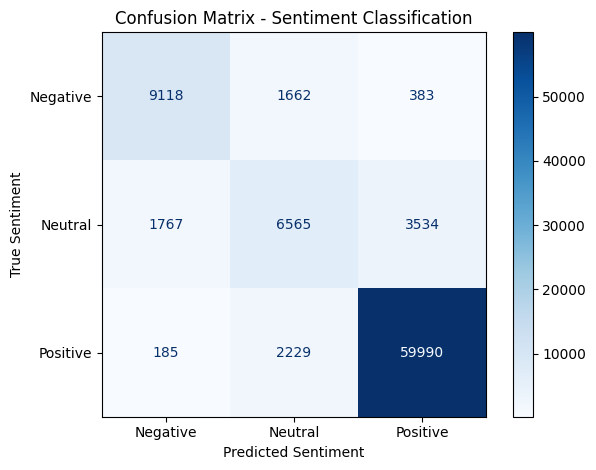

In [3]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load predictions
df = pd.read_csv("sentiment_analysis/test_predictions.csv")

# Confirm columns
print(df.columns)  # should include 'labels' and 'predicted_sentiment'

# Confusion matrix
true_labels = df["labels"]
pred_labels = df["predicted_sentiment"]

cm = confusion_matrix(true_labels, pred_labels, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Neutral", "Positive"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Sentiment Classification")
plt.xlabel("Predicted Sentiment")
plt.ylabel("True Sentiment")
plt.tight_layout()
plt.show()

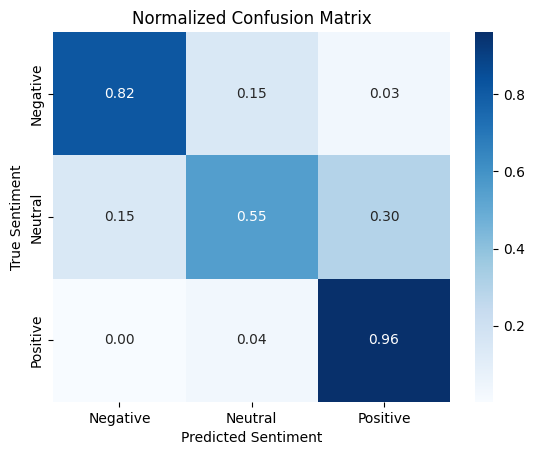

In [5]:
import seaborn as sns
import numpy as np

cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted Sentiment")
plt.ylabel("True Sentiment")
plt.title("Normalized Confusion Matrix")
plt.show()

# Rating Prediction

NOTE : instead of taking entire 800k entries -> slect only 100k entries for faster model training

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("processed_dataset/reviews_english.csv")

# Drop invalid ratings (e.g., 0)
initial_count = len(df)
df = df[df["rating_overall"] >= 1]
print(f"🧹 Dropped {initial_count - len(df)} entries with rating = 0")

df = df.dropna(subset=["title", "text", "rating_overall"])

df["labels"] = df["rating_overall"].astype(int) - 1

df["text"] = df["title"].str.strip() + "\n" + df["text"].str.strip()

df = df[["text", "labels"]]

# Take 1/8th of data with stratified sampling
sample_frac = 1 / 8
df_sampled, _ = train_test_split(
    df, 
    train_size=sample_frac, 
    stratify=df["labels"], 
    random_state=42
)

# Check label distribution
print("\n📊 Sampled rating class distribution (labels 0–4 → ratings 1–5):")
print(df_sampled["labels"].value_counts().sort_index())

# Save sampled version
df_sampled.to_csv("rating_classification/rating_dataset.csv", index=False)
print("\n✅ Saved reduced rating classification dataset to 'rating_classification/rating_dataset.csv'")

🧹 Dropped 14 entries with rating = 0

📊 Sampled rating class distribution (labels 0–4 → ratings 1–5):
labels
0     6630
1     7324
2    14833
3    35372
4    42631
Name: count, dtype: int64

✅ Saved reduced rating classification dataset to 'rating_classification/rating_dataset.csv'


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("rating_classification/rating_dataset.csv")

train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['labels'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['labels'], random_state=42)

train_df.to_csv("rating_classification/rating_train.csv", index=False)
val_df.to_csv("rating_classification/rating_val.csv", index=False)
test_df.to_csv("rating_classification/rating_test.csv", index=False)

# Print distribution
print(f"\n📊 Train size: {len(train_df)}")
print(f"📊 Validation size: {len(val_df)}")
print(f"📊 Test size: {len(test_df)}")

print("\n✅ Label distribution in train set:")
print(train_df["labels"].value_counts(normalize=True).sort_index())

print("\n✅ Label distribution in val set:")
print(val_df["labels"].value_counts(normalize=True).sort_index())

print("\n✅ Label distribution in test set:")
print(test_df["labels"].value_counts(normalize=True).sort_index())


📊 Train size: 85432
📊 Validation size: 10679
📊 Test size: 10679

✅ Label distribution in train set:
labels
0    0.062084
1    0.068581
2    0.138894
3    0.331234
4    0.399206
Name: proportion, dtype: float64

✅ Label distribution in val set:
labels
0    0.062084
1    0.068639
2    0.138871
3    0.331211
4    0.399195
Name: proportion, dtype: float64

✅ Label distribution in test set:
labels
0    0.062084
1    0.068546
2    0.138964
3    0.331211
4    0.399195
Name: proportion, dtype: float64


## DistillBERT

In [3]:
import psutil

# CPU info
num_cores = psutil.cpu_count(logical=True)
print(f"CPU Cores (Logical): {num_cores}")

# RAM info
ram_bytes = psutil.virtual_memory().total
ram_gb = ram_bytes / (1024 ** 3)
print(f"Total RAM: {ram_gb:.2f} GB")

CPU Cores (Logical): 32
Total RAM: 186.34 GB


### Parameters

In [4]:
import pandas as pd, numpy as np
import torch
from datasets import Dataset
from transformers import (DistilBertTokenizerFast, DistilBertForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding, TrainerCallback)

# Ensure GPU is used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

EPOCHS = 5
LEARNING_RATE = 1e-5  
WEIGHT_DECAY = 0.01
TRAIN_BATCH_SIZE = 128
EVAL_BATCH_SIZE = 128

CHECKPOINT = "distilbert-base-uncased"
OUTPUT_DIR = "rating_classification/distilbert"

/home/mohit/BTP/LSI-LegalBert/chiranjan/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


### Tokenization and Pre-Processing

In [5]:
from datasets import Dataset
import pandas as pd

train_df = pd.read_csv("rating_classification/rating_train.csv")
val_df = pd.read_csv("rating_classification/rating_val.csv")
test_df = pd.read_csv("rating_classification/rating_test.csv")

train_df["labels"] = train_df["labels"].astype(int)
val_df["labels"] = val_df["labels"].astype(int)
test_df["labels"] = test_df["labels"].astype(int)

train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)
test_ds = Dataset.from_pandas(test_df)

print("✅ Loaded and converted train/val/test to HuggingFace Dataset.")

✅ Loaded and converted train/val/test to HuggingFace Dataset.


In [6]:
print(test_ds)
train_ds[0]

Dataset({
    features: ['text', 'labels'],
    num_rows: 10679
})


{'text': '“Outstanding value”\nStayed here on the beginning edge of a long European trip, then stayed at the Edison on the other end. Liked the Red Roof Inn better. The rooms were clean, of adequate size for a party of 4, simple, nothing fancy, but just fine.\nWhen you consider the room rates, it becomes hard to complain at all.\nThe location is excellent, next to the Empire State Building and a close subway station. The service was excellent. \nThe breakfast was awful though. They should just not offer it at all. The breakfast room was packed tight. The food was so bad I would not touch it: white bagels hard as rocks, out of coffee, bananas - I think that was it. I asked the lone worker for an apple and he snarled that there were bananas already out. I felt sorry for him - he was entirely overwhelmed and probably spitting on all the food in the back room. We went out for breakfast.\nAnyway, I would absolutely stay here again - and over the Edison Hotel.\nReally a great place.',
 'labe

In [7]:
tokenizer = DistilBertTokenizerFast.from_pretrained(CHECKPOINT)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

print("Tokenizing datasets...")

train_ds = train_ds.map(tokenize, batched=True, batch_size=4096, num_proc=30)
val_ds = val_ds.map(tokenize, batched=True, batch_size=4096, num_proc=30)
test_ds = test_ds.map(tokenize, batched=True, batch_size=4096, num_proc=30)

Tokenizing datasets...


Map (num_proc=30): 100%|██████████| 10679/10679 [00:01<00:00, 8979.32 examples/s]


In [8]:
train_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

train_ds[0]

{'labels': tensor(4),
 'input_ids': tensor([  101,  1523,  5151,  3643,  1524,  4370,  2182,  2006,  1996,  2927,
          3341,  1997,  1037,  2146,  2647,  4440,  1010,  2059,  4370,  2012,
          1996, 17046,  2006,  1996,  2060,  2203,  1012,  4669,  1996,  2417,
          4412,  7601,  2488,  1012,  1996,  4734,  2020,  4550,  1010,  1997,
         11706,  2946,  2005,  1037,  2283,  1997,  1018,  1010,  3722,  1010,
          2498, 11281,  1010,  2021,  2074,  2986,  1012,  2043,  2017,  5136,
          1996,  2282,  6165,  1010,  2009,  4150,  2524,  2000, 17612,  2012,
          2035,  1012,  1996,  3295,  2003,  6581,  1010,  2279,  2000,  1996,
          3400,  2110,  2311,  1998,  1037,  2485, 10798,  2276,  1012,  1996,
          2326,  2001,  6581,  1012,  1996,  6350,  2001,  9643,  2295,  1012,
          2027,  2323,  2074,  2025,  3749,  2009,  2012,  2035,  1012,  1996,
          6350,  2282,  2001,  8966,  4389,  1012,  1996,  2833,  2001,  2061,
          2919,  

### Computing and Printing Metrices

In [9]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tabulate import tabulate
from torch.utils.data import DataLoader

def print_metrics(results):
    label_names = ["1", "2", "3", "4", "5"]  # Ratings as classes

    print("\n\033[1m📊 Model Evaluation Metrics:\033[0m")
    general_metrics = [
        ["Accuracy", f"{results['accuracy']:.4f}"],
        ["Macro Precision", f"{results['macro_precision']:.4f}"],
        ["Macro Recall", f"{results['macro_recall']:.4f}"],
        ["Macro F1", f"{results['macro_f1']:.4f}"],
        ["Weighted Precision", f"{results['weighted_precision']:.4f}"],
        ["Weighted Recall", f"{results['weighted_recall']:.4f}"],
        ["Weighted F1", f"{results['weighted_f1']:.4f}"]
    ]
    print(tabulate(general_metrics, headers=["Metric", "Value"], tablefmt="fancy_grid"))

    print("\n\033[1m📊 Per-Class Metrics:\033[0m")
    class_metrics = {
        "Rating": label_names,
        "F1-Score": [f"{results[f'rating_{r}_f1']:.4f}" for r in label_names],
        "Precision": [f"{results[f'rating_{r}_precision']:.4f}" for r in label_names],
        "Recall": [f"{results[f'rating_{r}_recall']:.4f}" for r in label_names]
    }
    print(tabulate(class_metrics, headers="keys", tablefmt="fancy_grid"))

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)

    # Macro and weighted
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro')
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(labels, preds, average='weighted')

    # Per-class
    precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(labels, preds, average=None)

    results = {
        "accuracy": accuracy_score(labels, preds),
        "macro_precision": precision_macro,
        "macro_recall": recall_macro,
        "macro_f1": f1_macro,
        "weighted_precision": precision_weighted,
        "weighted_recall": recall_weighted,
        "weighted_f1": f1_weighted
    }

    for i, rating in enumerate(["1", "2", "3", "4", "5"]):
        results[f"rating_{rating}_f1"] = f1_per_class[i]
        results[f"rating_{rating}_precision"] = precision_per_class[i]
        results[f"rating_{rating}_recall"] = recall_per_class[i]

    return results

class VerboseCallback(TrainerCallback):
    def __init__(self, model, val_dataset):
        self.model = model
        self.val_dataset = val_dataset

    def on_epoch_begin(self, args, state, control, **kwargs):
        print(f"\n🔁 Epoch {int(state.epoch) + 1} started...")

    def on_evaluate(self, args, state, control, **kwargs):
        print(f"\n📊 Evaluation after epoch {int(state.epoch)}:")

        val_loader = DataLoader(self.val_dataset, batch_size=EVAL_BATCH_SIZE)
        self.model.eval()

        all_logits = []
        all_labels = []

        with torch.no_grad():
            for batch in val_loader:
                inputs = {
                    "input_ids": batch["input_ids"].to(self.model.device),
                    "attention_mask": batch["attention_mask"].to(self.model.device)
                }
                labels = batch["labels"].to(self.model.device)
                outputs = self.model(**inputs)
                all_logits.append(outputs.logits.cpu())
                all_labels.append(labels.cpu())

        logits = torch.cat(all_logits).numpy()
        labels = torch.cat(all_labels).numpy()

        results = compute_metrics((logits, labels))
        print_metrics(results)

    def on_train_end(self, args, state, control, **kwargs):
        print("\n🏁 Training complete!")

### Model and Trainer Setpup

In [10]:
from math import ceil
model = DistilBertForSequenceClassification.from_pretrained(CHECKPOINT, num_labels=5).to(device)

args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    load_best_model_at_end=True,
    do_eval=True,
    eval_strategy="epoch",  
    save_strategy="epoch",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=EVAL_BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=WEIGHT_DECAY,
    metric_for_best_model="macro_f1",  
    logging_dir="sentiment_analysis/logs",
    report_to="none",
    fp16=True,
    logging_steps = int(0.05 * ((len(train_ds) // TRAIN_BATCH_SIZE) * EPOCHS)), # log every 5% of training
    save_total_limit=2,      
    lr_scheduler_type="linear",     
    warmup_steps = ceil(0.1 * (len(train_ds) / TRAIN_BATCH_SIZE) * EPOCHS)
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[VerboseCallback(model, val_ds)]
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_4865/2844767395.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


### Training and Evaluation

In [11]:
print("Starting training...")
trainer.train()

Starting training...

🔁 Epoch 1 started...


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted Precision,Weighted Recall,Weighted F1,Rating 1 F1,Rating 1 Precision,Rating 1 Recall,Rating 2 F1,Rating 2 Precision,Rating 2 Recall,Rating 3 F1,Rating 3 Precision,Rating 3 Recall,Rating 4 F1,Rating 4 Precision,Rating 4 Recall,Rating 5 F1,Rating 5 Precision,Rating 5 Recall
1,0.819800,0.789917,0.646409,0.605086,0.587577,0.591373,0.633966,0.646409,0.635147,0.713467,0.679400,0.751131,0.419281,0.477352,0.373806,0.492611,0.562284,0.438301,0.556996,0.596769,0.522194,0.774510,0.709627,0.852451
2,0.754300,0.746292,0.669445,0.626945,0.624896,0.621912,0.662495,0.669445,0.663197,0.734177,0.687747,0.787330,0.433888,0.516981,0.373806,0.564590,0.549458,0.580580,0.591677,0.633926,0.554707,0.785230,0.746616,0.828055
3,0.711300,0.729012,0.678153,0.640878,0.627101,0.632592,0.676467,0.678153,0.676651,0.734664,0.720290,0.749623,0.453374,0.510239,0.407913,0.558172,0.573665,0.543493,0.634768,0.616183,0.654509,0.781985,0.784013,0.779967
4,0.694100,0.728468,0.679090,0.641347,0.629525,0.634728,0.673778,0.679090,0.675778,0.737791,0.735030,0.740573,0.468975,0.497703,0.443383,0.557814,0.580598,0.536750,0.620293,0.630810,0.610122,0.788764,0.762593,0.816796
5,0.672200,0.728373,0.680401,0.645162,0.628688,0.636320,0.676749,0.680401,0.678226,0.735632,0.747664,0.723982,0.471273,0.504673,0.442019,0.558365,0.574074,0.543493,0.628458,0.627573,0.629347,0.787872,0.771827,0.804598



📊 Evaluation after epoch 1:

📊 Model Evaluation Metrics:
╒════════════════════╤═════════╕
│ Metric             │   Value │
╞════════════════════╪═════════╡
│ Accuracy           │  0.6464 │
├────────────────────┼─────────┤
│ Macro Precision    │  0.6051 │
├────────────────────┼─────────┤
│ Macro Recall       │  0.5876 │
├────────────────────┼─────────┤
│ Macro F1           │  0.5914 │
├────────────────────┼─────────┤
│ Weighted Precision │  0.634  │
├────────────────────┼─────────┤
│ Weighted Recall    │  0.6464 │
├────────────────────┼─────────┤
│ Weighted F1        │  0.6351 │
╘════════════════════╧═════════╛

📊 Per-Class Metrics:
╒══════════╤════════════╤═════════════╤══════════╕
│   Rating │   F1-Score │   Precision │   Recall │
╞══════════╪════════════╪═════════════╪══════════╡
│        1 │     0.7135 │      0.6794 │   0.7511 │
├──────────┼────────────┼─────────────┼──────────┤
│        2 │     0.4193 │      0.4774 │   0.3738 │
├──────────┼────────────┼─────────────┼──────────┤
│ 

TrainOutput(global_step=3340, training_loss=0.7722265757486492, metrics={'train_runtime': 352.6705, 'train_samples_per_second': 1211.216, 'train_steps_per_second': 9.471, 'total_flos': 1.41469503343104e+16, 'train_loss': 0.7722265757486492, 'epoch': 5.0})

In [12]:
print("\nFinal Evaluation on Test Set:")
print(trainer.evaluate(test_ds))


Final Evaluation on Test Set:



📊 Evaluation after epoch 5:

📊 Model Evaluation Metrics:
╒════════════════════╤═════════╕
│ Metric             │   Value │
╞════════════════════╪═════════╡
│ Accuracy           │  0.6804 │
├────────────────────┼─────────┤
│ Macro Precision    │  0.6452 │
├────────────────────┼─────────┤
│ Macro Recall       │  0.6287 │
├────────────────────┼─────────┤
│ Macro F1           │  0.6363 │
├────────────────────┼─────────┤
│ Weighted Precision │  0.6767 │
├────────────────────┼─────────┤
│ Weighted Recall    │  0.6804 │
├────────────────────┼─────────┤
│ Weighted F1        │  0.6782 │
╘════════════════════╧═════════╛

📊 Per-Class Metrics:
╒══════════╤════════════╤═════════════╤══════════╕
│   Rating │   F1-Score │   Precision │   Recall │
╞══════════╪════════════╪═════════════╪══════════╡
│        1 │     0.7356 │      0.7477 │   0.724  │
├──────────┼────────────┼─────────────┼──────────┤
│        2 │     0.4713 │      0.5047 │   0.442  │
├──────────┼────────────┼─────────────┼──────────┤
│ 

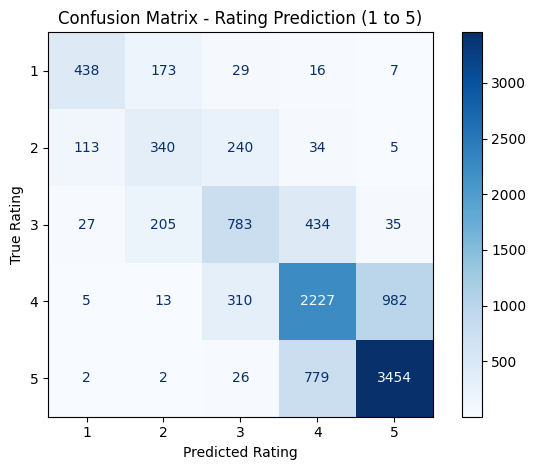

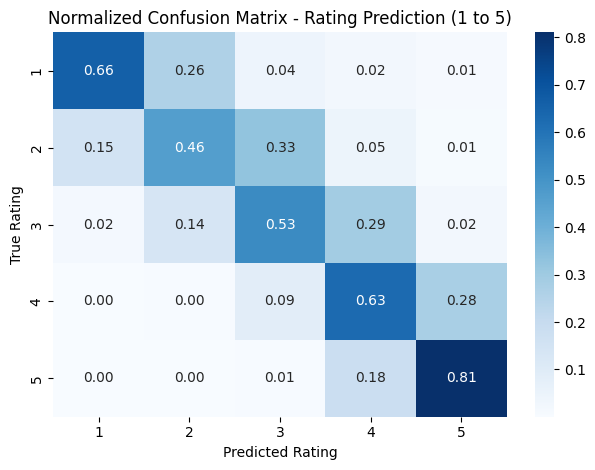

In [21]:
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

pred_output = trainer.predict(test_ds)
preds = np.argmax(pred_output.predictions, axis=1)  # predicted class (0–4)

test_df = pd.read_csv("rating_classification/rating_test.csv")  # update path if needed
true_labels = test_df["labels"].astype(int).values  # ground truth (also 0–4)

# Compute confusion matrix
cm = confusion_matrix(true_labels, preds, labels=[0, 1, 2, 3, 4])

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3, 4, 5])
disp.plot(cmap='Blues', values_format='d', xticks_rotation=0)

plt.title("Confusion Matrix - Rating Prediction (1 to 5)")
plt.xlabel("Predicted Rating")
plt.ylabel("True Rating")
plt.tight_layout()
plt.show()

cm = confusion_matrix(true_labels, preds, labels=[0, 1, 2, 3, 4])
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.title("Normalized Confusion Matrix - Rating Prediction (1 to 5)")
plt.xlabel("Predicted Rating")
plt.ylabel("True Rating")
plt.tight_layout()
plt.show()

In [22]:
import pandas as pd
import numpy as np

trainer.save_model("rating_classification/model")
tokenizer.save_pretrained("rating_classification/model")

log_history = trainer.state.log_history
log_df = pd.DataFrame(log_history)
log_df.to_csv("rating_classification/training_logs.csv", index=False)
print("\n✅ Saved training logs to 'training_logs.csv'")

preds_output = trainer.predict(test_ds)
preds = np.argmax(preds_output.predictions, axis=1)  # 0–4 classes

predicted_ratings = preds + 1

test_df = pd.read_csv("rating_classification/rating_test.csv")  # Reload original to get true labels
test_df["predicted_rating"] = predicted_ratings

# Save results
test_df.to_csv("rating_classification/test_predictions.csv", index=False)
print("\n✅ Saved test predictions to 'test_predictions.csv'")


✅ Saved training logs to 'training_logs.csv'



✅ Saved test predictions to 'test_predictions.csv'


### Inference Testing

In [ ]:
import torch
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast
import numpy as np

model_path = "rating_classification/model"  
model = DistilBertForSequenceClassification.from_pretrained(model_path)
tokenizer = DistilBertTokenizerFast.from_pretrained(model_path)
model.eval()

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def predict_rating(text):

    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()

    predicted_rating = predicted_class + 1

    print(f"\n📝 Input: {text[:100]}{'...' if len(text) > 100 else ''}")
    print(f"⭐ Predicted Rating: {predicted_rating} (class {predicted_class})")

    return predicted_rating

In [24]:
text = "This hotel had an amazing location and the staff were incredibly helpful. Loved the breakfast too!"
predict_rating(text)


📝 Input: This hotel had an amazing location and the staff were incredibly helpful. Loved the breakfast too!
⭐ Predicted Rating: 5 (class 4)


5